In [1]:
import pandas as pd 
import ast 

In [2]:
file_path = "/Users/flint/Data/recipe/italian/gz_recipe.csv"

In [25]:
data = pd.read_csv(file_path, index_col=0)
data = data.dropna()
data.head()

,Nome,Categoria,Link,Persone/Pezzi,Ingredienti,Steps
0,Tiramisù,Dolci,https://ricette.giallozafferano.it/Tiramisu.html,8,"[['Mascarpone', '750g'], ['Uova', '260g'], ['S...",Per preparare il tiramisù preparate il caffé c...
1,Cookies,Dolci,https://ricette.giallozafferano.it/Cookies.html,12,"[['Farina 00', '195g'], ['Burro', '100g'], ['B...","Per preparare i cookies, assicuratevi che il b..."
2,Pancake allo sciroppo d'acero,Dolci,https://ricette.giallozafferano.it/Pancakes-al...,4,"[['Burro', '25g'], ['Farina 00', '125g'], ['Uo...",Iniziamo la preparazione dei pancake fondendo ...
3,Crema al mascarpone,Dolci,https://ricette.giallozafferano.it/Crema-al-ma...,4,"[['Mascarpone', '500g'], ['Zucchero', '125g'],...",Per preparare la crema al mascarpone versate i...
4,Crepe dolci e salate (ricetta base),Dolci,https://ricette.giallozafferano.it/Crepes-dolc...,15,"[['Uova', '3'], ['Farina 00', '250g'], ['Latte...",Per preparare le crepe dolci e salate iniziate...


In [26]:
raw_ingredients = [ast.literal_eval(x) for x in data['Ingredienti'].values]
ingredient_table = []
for i, name in enumerate(data['Nome']):
    ingredients_list = raw_ingredients[i]
    for ingredient, quantity in ingredients_list:
        try:
            qta = int(quantity[:-1])
        except Exception:
            qta = 1
        ingredient_table.append({
            'ricetta': i,
            'ingrediente': ingredient,
            'qta': qta
        })
ingredients = pd.DataFrame(ingredient_table)

In [42]:
ingredients[ingredients['ricetta'] == 0]

,ricetta,ingrediente,qta
0,0,Mascarpone,750
1,0,Uova,260
2,0,Savoiardi,250
3,0,Zucchero,120
4,0,Caffè,300
5,0,Cacao amaro in polvere,1


## Creazione della matrice documenti $\times$ termini (in questo caso ricetta $\times$ ingrediente)

In [28]:
import numpy as np 

In [43]:
vocabulary = sorted(ingredients.ingrediente.unique())
print(len(vocabulary), vocabulary[:4])
ingredient2id = dict([(x, i) for i, x in enumerate(vocabulary)])
id2ingredient = dict([(i, x) for i, x in enumerate(vocabulary)])
recipe2id = dict([(x, i) for i, x in enumerate(data['Nome'].values)])
id2recipe = dict([(i, x) for i, x in enumerate(data['Nome'].values)])

1641 ['Abbacchio', 'Acai in polvere', 'Acciughe (alici)', "Acciughe sott'olio"]


In [30]:
matrix = np.zeros((data.shape[0], len(vocabulary)))
for i, row in ingredients.iterrows():
    recipe = row['ricetta']
    ingredient = row['ingrediente']
    qta = row['qta']
    matrix[recipe, ingredient2id[ingredient]] = qta 

In [31]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
test = 'Crema al mascarpone'
test_vector = pd.Series(matrix[recipe2id[test]], index=vocabulary)
test_vector.sort_values(ascending=False)

Mascarpone                     500.0
Zucchero                       125.0
Acqua                           50.0
Tuorli                           1.0
Cacao amaro in polvere           1.0
                               ...  
Fichi                            0.0
Fettuccine all'uovo              0.0
Fettuccine 5 cereali e uova      0.0
Fettuccine                       0.0
zenzero candito                  0.0
Length: 1641, dtype: float64

In [44]:
from sklearn.manifold import TSNE

In [45]:
embedding = TSNE(n_components=2)
matrix_2d = embedding.fit_transform(matrix)

In [46]:
matrix_2d[recipe2id[test]]

array([ 27.523787, -57.86485 ], dtype=float32)

0                                    Tiramisù
1                                     Cookies
2               Pancake allo sciroppo d'acero
3                         Crema al mascarpone
4         Crepe dolci e salate (ricetta base)
5                      Lasagne alla Bolognese
6                                 Besciamella
7                          Pasta per la pizza
8    Biscotti di Pan di zenzero (gingerbread)
9                    Spaghetti alla Carbonara
Name: Nome, dtype: object


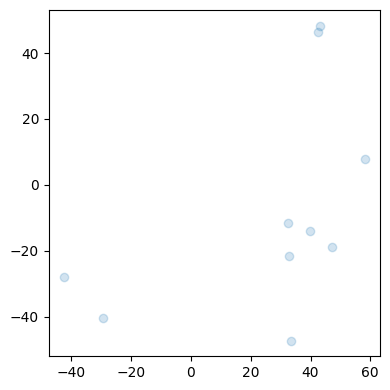

In [51]:
categories = sorted(list(data['Categoria'].unique()))
cat2id = dict([(x, i) for i, x in enumerate(categories)])
category_labels = [cat2id[c] for c in data['Categoria']]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(matrix_2d[:10, 0], matrix_2d[:10, 1], alpha=0.2)
plt.tight_layout()
print(data['Nome'][:10])
plt.show()

### Similarità fra ricette

In [52]:
from sklearn.metrics.pairwise import pairwise_distances

In [53]:
sigma = pairwise_distances(matrix, matrix, metric='euclidean')

In [54]:
test = 'Focaccia col formaggio (di Recco)'
test_id = recipe2id[test]
sigma[test_id]

array([380802.11929163, 380801.21858524, 380801.14701639, ...,
       380801.44768501, 380801.01658215, 380801.8933632 ])

In [55]:
most_similar = pd.Series(sigma[test_id], index=data['Nome']).sort_values(ascending=True)
most_similar

Nome
Focaccia col formaggio (di Recco)                                                          0.000000e+00
Panini delle feste                                                                         3.800511e+05
Stollen                                                                                    3.801013e+05
Focaccia con alici, fiori di zucca e burrata                                               3.802009e+05
Jerusalem bagel                                                                            3.802011e+05
                                                                                               ...     
Sigari con caprino e miele al rosmarino                                                    4.522994e+05
Maritozzi golosi                                                                           4.976602e+05
Gnocchi coi Useleti (Gnocchi con gli involtini di carne)                                   5.898818e+05
Cestini di pasta fillo con cremoso di cioccolato bianco e c

In [57]:
query = np.zeros(len(vocabulary))
query_ingredients = np.random.choice(vocabulary, size=4)
query_ingredients

array(['Miele di timo', 'Topinambur', 'Grano per pastiera',
       'Olive riviera'], dtype='<U62')

In [61]:
quantities = [3, 150, 20, 10]
for i, x in enumerate(query_ingredients):
    query[ingredient2id[x]] = quantities[i]

In [63]:
pd.Series(query, index=vocabulary).sort_values(ascending=False)

Topinambur                     150.0
Grano per pastiera              20.0
Olive riviera                   10.0
Miele di timo                    3.0
Pepe giamaicano                  0.0
                               ...  
Fettuccine 5 cereali e uova      0.0
Fettuccine                       0.0
Fettine di vitello               0.0
Fettine di manzo                 0.0
zenzero candito                  0.0
Length: 1641, dtype: float64

In [65]:
search = pairwise_distances([query], matrix, metric='euclidean')
pd.Series(search[0], index=data['Nome'].values).sort_values(ascending=True)

Sfoglie con topinambur trifolati                                                           5.492722e+01
Sfoglie alle olive con topinambur e raspadura                                              1.030291e+02
Caldarroste                                                                                1.516905e+02
Uova alla coque                                                                            1.516905e+02
Pomodori pelati                                                                            1.516905e+02
                                                                                               ...     
Maritozzi golosi                                                                           3.204003e+05
Focaccia col formaggio (di Recco)                                                          3.808011e+05
Gnocchi coi Useleti (Gnocchi con gli involtini di carne)                                   4.505010e+05
Cestini di pasta fillo con cremoso di cioccolato bianco e confet

In [67]:
pd.Series(matrix[recipe2id['Sfoglie con topinambur trifolati']], index=vocabulary).sort_values(ascending=False)

Topinambur                     100.0
Sale fino                        1.0
Prezzemolo                       1.0
Menta                            1.0
Pepe nero                        1.0
                               ...  
Fettuccine 5 cereali e uova      0.0
Fettuccine                       0.0
Fettine di vitello               0.0
Fettine di manzo                 0.0
zenzero candito                  0.0
Length: 1641, dtype: float64

In [68]:
pd.Series(matrix[recipe2id['Sfoglie alle olive con topinambur e raspadura']], index=vocabulary).sort_values(ascending=False)

Topinambur                     140.0
Brodo vegetale                 100.0
Raspadura                        1.0
Prezzemolo                       1.0
La Bottega di Olivia&Marino      1.0
                               ...  
Fettuccine all'uovo              0.0
Fettuccine 5 cereali e uova      0.0
Fettuccine                       0.0
Fettine di vitello               0.0
zenzero candito                  0.0
Length: 1641, dtype: float64

### Scalare i dati

In [69]:
from sklearn.preprocessing import MinMaxScaler

In [71]:
scaler = MinMaxScaler()
matrix_scaled = scaler.fit_transform(matrix)
pd.Series(matrix_scaled[recipe2id['Sfoglie con topinambur trifolati']], index=vocabulary).sort_values(ascending=False)

La Bottega di Olivia&Marino    0.500000
Topinambur                     0.125000
Maggiorana                     0.040000
Pepe nero                      0.033333
Timo                           0.020000
                                 ...   
Fettuccine 5 cereali e uova    0.000000
Fettuccine                     0.000000
Fettine di vitello             0.000000
Fettine di manzo               0.000000
zenzero candito                0.000000
Length: 1641, dtype: float64

In [74]:
query_scaled = scaler.transform([query])

In [75]:
search = pairwise_distances(query_scaled, matrix_scaled, metric='euclidean')
pd.Series(search[0], index=data['Nome'].values).sort_values(ascending=True)

Uova alla coque                                0.297358
Uova sode                                      0.297358
Caldarroste                                    0.297360
Maccheroni alla chitarra                       0.297360
Castagne al forno                              0.297361
                                                 ...   
Cheesecake leggera                             2.324074
Galletto al sale                               2.401803
Pulled pork                                    2.760313
Casetta di pan di spezie                       2.782263
Costine di maiale affumicate di Kansas City    2.873851
Length: 5933, dtype: float64

In [76]:
pd.Series(matrix_scaled[recipe2id['Uova alla coque']], index=vocabulary).sort_values(ascending=False)

Uova                           0.000238
Abbacchio                      0.000000
Pennette rigate 5 cereali      0.000000
Pepe giamaicano                0.000000
Pepe di Sichuan                0.000000
                                 ...   
Fettuccine all'uovo            0.000000
Fettuccine 5 cereali e uova    0.000000
Fettuccine                     0.000000
Fettine di vitello             0.000000
zenzero candito                0.000000
Length: 1641, dtype: float64

### Clustering

In [37]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

In [38]:
embedding = TSNE(n_components=2)
matrix_2d = embedding.fit_transform(matrix)

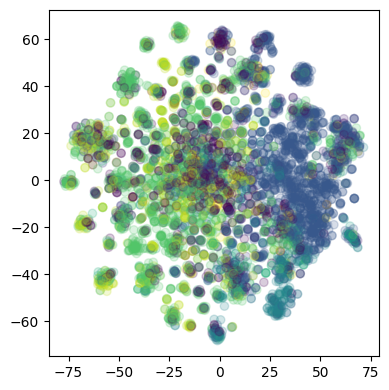

In [41]:
categories = sorted(list(data['Categoria'].unique()))
cat2id = dict([(x, i) for i, x in enumerate(categories)])
category_labels = [cat2id[c] for c in data['Categoria']]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(matrix_2d[:,0], matrix_2d[:,1], alpha=0.2, c=category_labels)
plt.tight_layout()
plt.show()

## Manipolazione del testo della ricetta
Invece degli ingredienti, utilizziamo il testo tokenizzato

In [77]:
from tqdm.notebook import tqdm
from transformers import BertTokenizer

In [78]:
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-italian-uncased")

In [79]:
recipes_text = data['Steps'].values 
vocabulary = set()
recipes_tokens = []
for text in tqdm(recipes_text):
    try:
        tokens = tokenizer.tokenize(text)
        vocabulary = vocabulary.union(set(tokens))
        recipes_tokens.append(tokens)
    except TypeError:
        recipes_tokens.append([])

  0%|          | 0/5933 [00:00<?, ?it/s]

In [83]:
vocabulary = sorted(list(vocabulary))
word2id = dict(zip(vocabulary, range(len(vocabulary))))
id2word = dict(zip(range(len(vocabulary)), vocabulary))
X = np.zeros((data.shape[0], len(vocabulary)))
for recipe, tokens in enumerate(recipes_tokens):
    for token in tokens:
        X[recipe, word2id[token]] += 1

In [84]:
X

array([[1., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 3., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [86]:
query = "cosa preparare usando il topinambur"
query_tokens = tokenizer.tokenize(query)
q_vector = np.zeros(len(vocabulary))
for token in query_tokens:
    try:
        token_id = word2id[token]
        q_vector[token_id] += 1
    except KeyError:
        pass

In [87]:
search = pairwise_distances([q_vector], X, metric='euclidean')
pd.Series(search[0], index=data['Nome'].values).sort_values(ascending=True)

Bruschette al lardo e rosmarino                 4.582576
Chips di patate                                 5.567764
Doppie meringhe con panna montata al cacao      5.567764
Mostarda di Cremona                             5.830952
Zucchine trifolate                              6.244998
                                                 ...    
Tiramisù goloso                               113.388712
Shish Kebab di tacchino                       117.847359
Casetta di pan di spezie                      122.686593
Torta libro                                   132.615987
Torta Barbie                                  162.619187
Length: 5933, dtype: float64

In [92]:
test = 'Focaccia col formaggio (di Recco)'
test_id = recipe2id[test]
bow = pd.Series(X[test_id], index=vocabulary)

In [93]:
bow.sort_values(ascending=False).head(10)

,      25.0
.      24.0
di     21.0
e      20.0
la     18.0
con    15.0
a      13.0
una    13.0
in     12.0
per    12.0
dtype: float64

In [95]:
test = 'Bruschette al lardo e rosmarino'
test_id = recipe2id[test]
bow = pd.Series(X[test_id], index=vocabulary)
bow.sort_values(ascending=False).head(10)

quarti      1.0
il          1.0
lava        1.0
pomodori    1.0
e           1.0
##tate      1.0
##ni        1.0
pane        1.0
.           1.0
in          1.0
dtype: float64

In [102]:
X = (X.T / X.sum(axis=1)).T

In [107]:
test = 'Focaccia col formaggio (di Recco)'
test_id = recipe2id[test]
bow = pd.Series(X[test_id], index=vocabulary)
bow.sort_values(ascending=False).head(10)

,      0.031368
.      0.030113
di     0.026349
e      0.025094
la     0.022585
con    0.018821
a      0.016311
una    0.016311
in     0.015056
per    0.015056
dtype: float64

In [105]:
test = 'Bruschette al lardo e rosmarino'
test_id = recipe2id[test]
bow = pd.Series(X[test_id], index=vocabulary)
bow.sort_values(ascending=False).head(10)

quarti      0.0625
il          0.0625
lava        0.0625
pomodori    0.0625
e           0.0625
##tate      0.0625
##ni        0.0625
pane        0.0625
.           0.0625
in          0.0625
dtype: float64

## Similarità lessicale

In [ ]:
sigma_words = pairwise_distances(X, X, metric='euclidean')

In [ ]:
most_similar = pd.Series(sigma_words[test_id], index=data['Nome']).sort_values(ascending=True)
most_similar.sort_values()